# Welcome to city-scale hotspot mapping using TARGET

---

Can you recommend to the government which parts of the city need cooling interventions?
* What are the hotspots of the city?
* What causes these areas to become hotter than others?
* What type amount of cooling can be achieved?
* By what type of interventions?


To answer these questions, we invite you to dive into the model results:
* Understand the city, its context, and how it's represented in the model
* Explore the heatwave characteristics and urban patterns
* Make sense of the output, its patterns, and what it reveals

But ... don't feel limited by what we've provided!

Feel free to bring in your own tools, datasets, and creative approaches ...whatever you feel comfortable with or curious about. Hackathons are meant for exploration, not constraint.

Enjoy!
---

## Setting up what we need...

* Mount the Google Drive, to access files and datasets
* Install the required packages and tools
* Set up directory and filenames (**some need to be adjusted**)

In [1]:
# Some Initial imports
import os, re, sys
import warnings
import importlib
from datetime import datetime
from glob import glob

# Ignore some warnings
warnings.filterwarnings("ignore", message=".*find_spec.*", category=ImportWarning)
for warning_type in [ImportWarning, SyntaxWarning, DeprecationWarning, UserWarning, RuntimeWarning]:
    warnings.filterwarnings("ignore", category=warning_type)

In [2]:
# Mount Google Drive, to access the datasets and write your results.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [99]:
# ===> SETTINGS TO ADJUST <====

# Your name - refers to the Google Drive folder name
YOUR_NAME = "Vihan"

# city of interest
city = "Timbuktu"
# city = "Davao"

# the simulation's run name
  # => By default, this is set to baseline, representing current conditions.

  # => Alternative scenarios can be done as well. For demonstration purposes, we’ve included
  # a predefined scenario where each neighbourhoog has one third of its concrete surface
  # converted to trees. For Davao that's been done region-wide, for Timbuktu
  # only for neighbourhoods with at least 10% of buildings (less than half of the pixels)
  # Reach out to the support team in case you want to try something else ...
# scenario_name = "baseline"
# scenario_name = "more_trees"
# scenario_name = "s1_targeted_greening"
scenario_name = "s2_reflective_roof"

# Your own baseline directory - check where you have mounted the ICUC12_Hackathon folder
BASE_DIR = os.path.join('/content/drive/MyDrive/ICUC12_Hackathon')
print('> BASE_DIR: ',BASE_DIR)

> BASE_DIR:  /content/drive/MyDrive/ICUC12_Hackathon


In [100]:
# ===> SETTINGS NOT TO CHANGE <====

# Setting files and directories, based on personal folder, city, and scenario
model = "TARGET"

# Create a link to your personal directory
PERSONAL_FOLDER = os.path.join(BASE_DIR, YOUR_NAME)
print('> PERSONAL_FOLDER: ', PERSONAL_FOLDER)

# Figure folder, to store all your nice visuals
FIGURE_FOLDER = os.path.join(PERSONAL_FOLDER, "figures")
print('> FIGURE_FOLDER: ', FIGURE_FOLDER)

# Create link to shared directory
SHARED_DIR = os.path.join(BASE_DIR, "SHARED_FOLDER")
print('> SHARED_DIR: ',SHARED_DIR)

# Path to shared notebooks
SHARED_FUNCTIONS = os.path.join(SHARED_DIR, "functions")
print(f'> SHARED FUNCTIONS FOLDER: ',SHARED_FUNCTIONS)

# Set MODEL INPUT DATA folder, is the shared data folder
MODEL_INPUT_FOLDER = os.path.join(SHARED_DIR, "data", city, model, scenario_name)
print(f'> {model} INPUT FOLDER: ', MODEL_INPUT_FOLDER)

# Set MODEL OUTPUT folder, under your own personal directory
MODEL_OUTPUT_FOLDER = os.path.join(PERSONAL_FOLDER, city, model, scenario_name)
print(f'> {model} OUTPUT FOLDER: ', MODEL_OUTPUT_FOLDER)

# Paths to initial and updated configsolweig.ini file.
# configsolweig.ini is created below
MODEL_CONFIG_INITIAL = os.path.join(os.path.dirname(MODEL_INPUT_FOLDER), 'config.ini')
MODEL_CONFIG_UPDATED = os.path.join(MODEL_OUTPUT_FOLDER, 'config.ini')
MODEL_PARAM_INITIAL = os.path.join(os.path.dirname(MODEL_INPUT_FOLDER), 'parameters.json')
print(f'> {model} CONFIG INITIAL: ', MODEL_CONFIG_INITIAL)
print(f'> {model} CONFIG UPDATED written to: ', MODEL_CONFIG_UPDATED)
print(f'> {model} PARAM INITIAL: ', MODEL_PARAM_INITIAL)

# Create some folders that might not exist
for folder in [
    MODEL_OUTPUT_FOLDER,
    FIGURE_FOLDER
    ]:
  if not os.path.exists(folder):
    os.makedirs(folder)

> PERSONAL_FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/Vihan
> FIGURE_FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/Vihan/figures
> SHARED_DIR:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER
> SHARED FUNCTIONS FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/functions
> TARGET INPUT FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/s2_reflective_roof
> TARGET OUTPUT FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/Vihan/Timbuktu/TARGET/s2_reflective_roof
> TARGET CONFIG INITIAL:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/config.ini
> TARGET CONFIG UPDATED written to:  /content/drive/MyDrive/ICUC12_Hackathon/Vihan/Timbuktu/TARGET/s2_reflective_roof/config.ini
> TARGET PARAM INITIAL:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/parameters.json


## Some installations and imports...



In [9]:
# Install a bunch of packages - with "-q" option to reduce verbose output
!pip install -q import_ipynb geopandas folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.8 MB/s eta 0:00:00


In [10]:
# Install the TARGET model (python version)
# INFO: https://github.com/jixuan-chen/target
!pip install -q target-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.4/651.4 kB 20.5 MB/s eta 0:00:00


In [101]:
# Load libraries
import json
from target_py import Target
from target_py import generate_example
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
%matplotlib inline

In [107]:
# Import functions from other notebook in Google Colab
import import_ipynb
os.chdir(SHARED_FUNCTIONS)

# import all functions made for this course
import target_functions
importlib.reload(target_functions)

from target_functions import get_city_info
from target_functions import make_interactive_map_roi
from target_functions import make_static_map_roi
from target_functions import plot_heatwave_characteristics
from target_functions import update_target_config
from target_functions import change_param_values
from target_functions import target_npy_to_df
from target_functions import plot_daily_stats_on_interactive_map
from target_functions import plot_daily_stats_on_static_map
from target_functions import scatter_variable_vs_surface
from target_functions import plot_timesereries_hex_of_interest
from target_functions import make_interactive_map_roi_compare
from target_functions import plot_daily_stats_on_static_map_scenarios
from target_functions import plot_timesereries_hex_of_interest_scen

In [109]:
# Based on the city, read some info that is city specific and that
# will be used in subsequent steps
cityInfo = get_city_info(city)
print(cityInfo)

{'lat': 16.774166, 'domainDim': 217, 'date1a': '2013,5,20,0', 'date1': '2013,5,20,0', 'date2': '2013,5,26,23'}


# Let's get started

## Context

* what is our area of interest?
* what are the characteristics of the selected heatwave event?
* how is the area represented in the model?


In [110]:
# Make interactive map of how TARGET sees the underlying surface
# Properties are aggregated over the hex grid

make_interactive_map_roi(MODEL_INPUT_FOLDER)

File saved: True


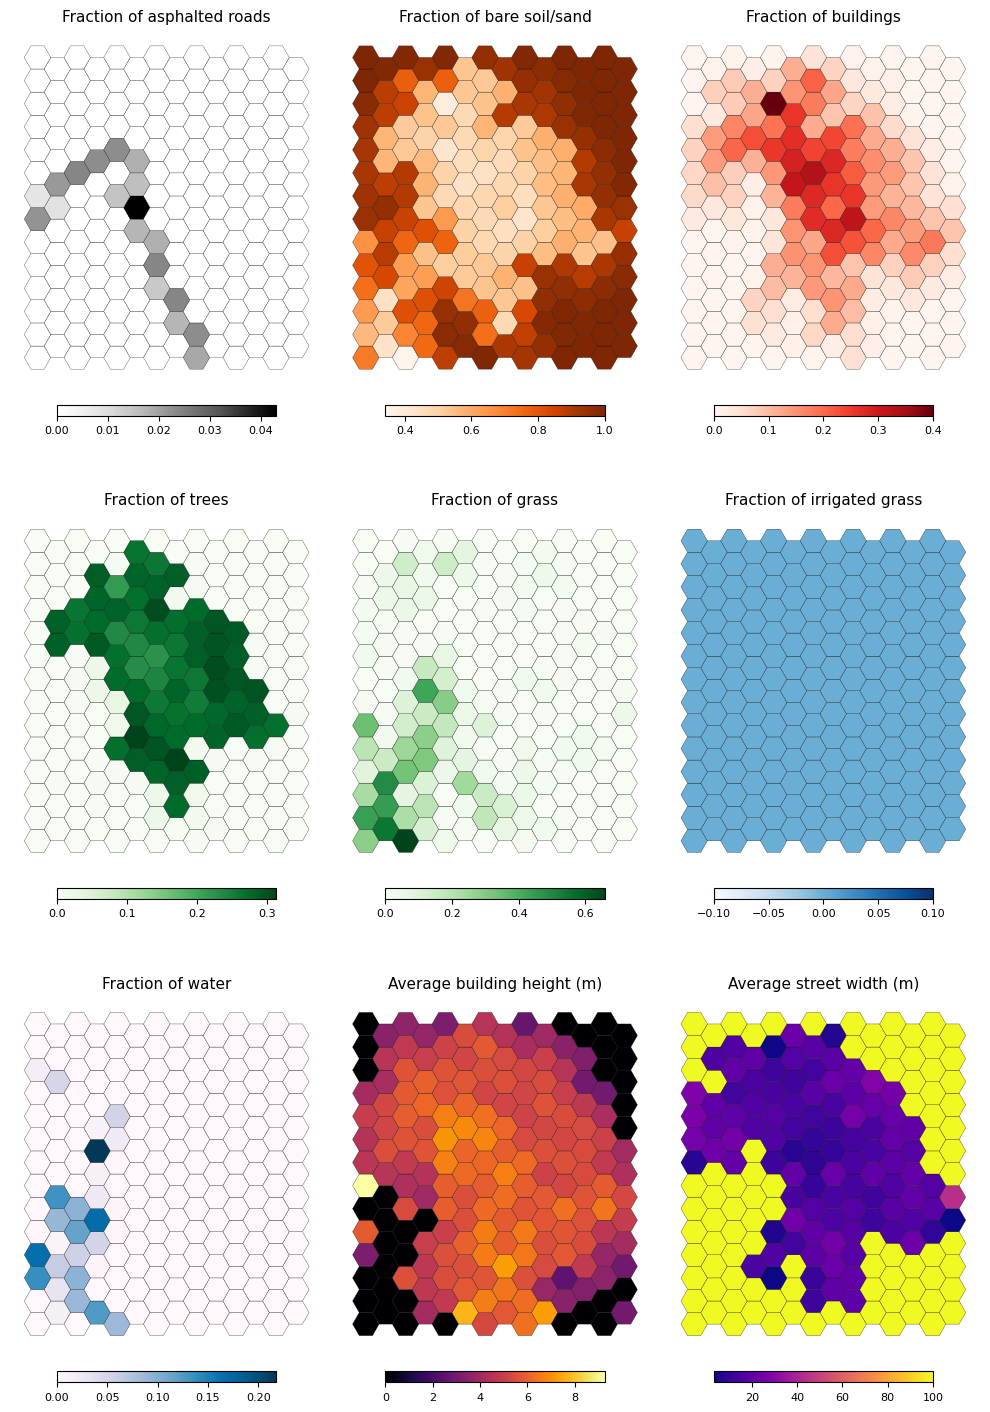

In [111]:
# Same as above, but now all together on static maps

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name}_plot_roi.png")
make_static_map_roi(MODEL_INPUT_FOLDER, figname)

File saved: True


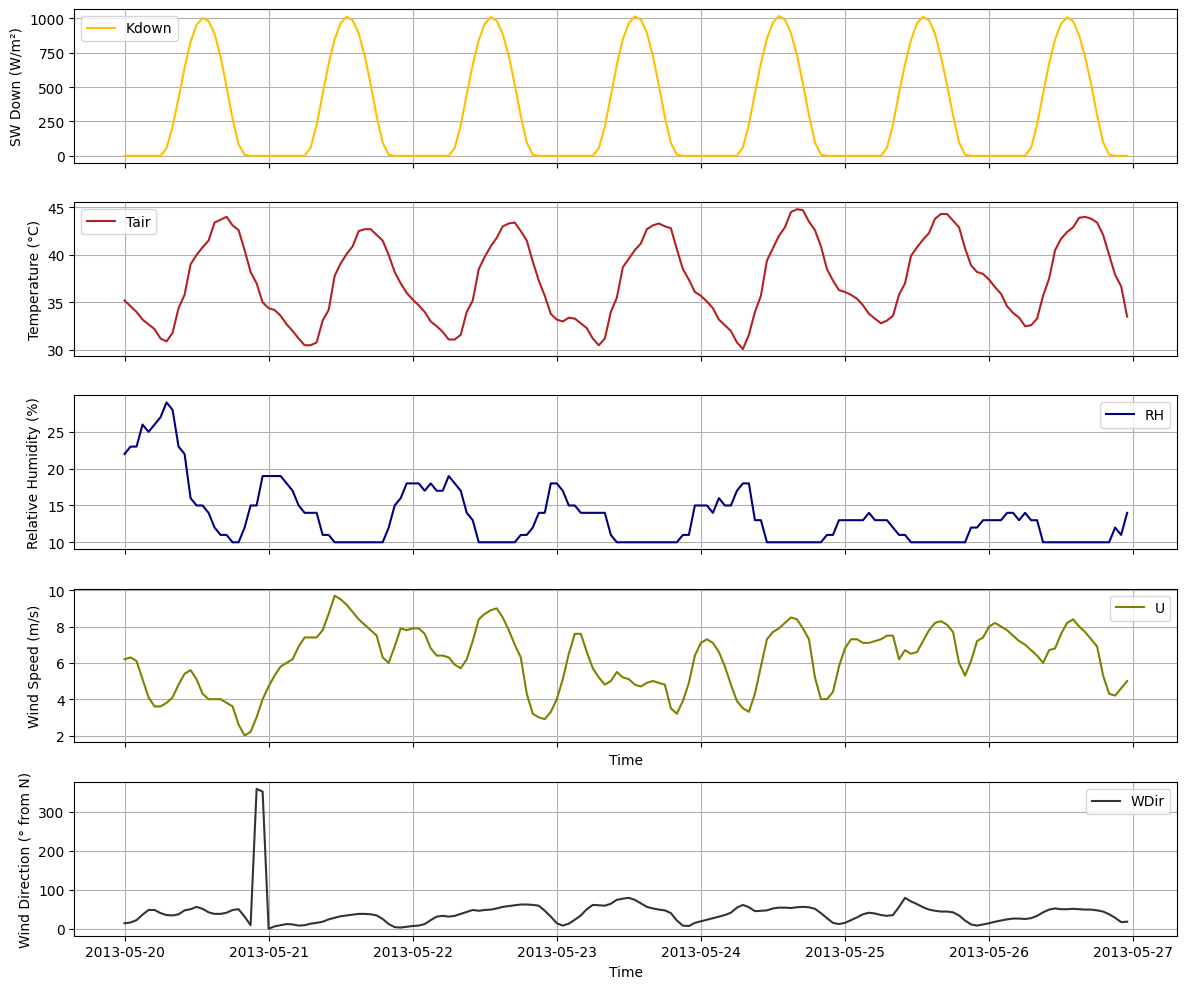

In [112]:
# How does the meteorology looks like during the selected heat-wave?

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name}_plot_heatwave_characteristics.png")
plot_heatwave_characteristics(MODEL_INPUT_FOLDER, figname)

## Calculate city-scale overheating

* Run TARGET to get T2M

In [113]:
# Update the config.ini files for your case
config = update_target_config(
    city,
    cityInfo,
    scenario_name,
    MODEL_CONFIG_INITIAL,
    MODEL_CONFIG_UPDATED,
    MODEL_PARAM_INITIAL,
    MODEL_INPUT_FOLDER,
    MODEL_OUTPUT_FOLDER
)

work_dir = /content/drive/MyDrive/ICUC12_Hackathon/Vihan/Timbuktu/TARGET/s2_reflective_roof
para_json_path = /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/parameters.json
site_name = Timbuktu
run_name = output
inpt_met_file = /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/s2_reflective_roof/MET/target_forcing.csv
inpt_lc_file = /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Timbuktu/TARGET/s2_reflective_roof/LC/lc_target.csv
date_fmt = %d/%m/%Y %H:%M
timestep = 60
mod_ldwn = N
include roofs = N
lat = 16.774166
domainDim = 217
latEdge = -34.79829
lonEdge = 138.79829
latResolution = 0.00088
lonResolution = 0.00110
z_URef = 10.0
zavg = 4.5
date1a = 2013,5,20,0
date1 = 2013,5,20,0
date2 = 2013,5,26,23

Updated config.ini saved to:
 /content/drive/MyDrive/ICUC12_Hackathon/Vihan/Timbuktu/TARGET/s2_reflective_roof/config.ini


In [114]:
# creating a model instance and loading configuration
tar = Target(
  MODEL_CONFIG_UPDATED,   # Load the updated config.ini file
  progress=True            # show progress bars
  )
tar.load_config()

[2025-07-08 15:35:41 - INFO] - loading config


INFO:streamLogger:loading config


In [85]:
change_param_values(tar, city)

> Values before change ...
alb: 0.2
emis: 0.94
C: 2110000.0
K: 7.2e-07
LUMPS1: [0.61, 0.28, -23.9]
alphapm: 0.0
beta: 3.0

> Values after change ...
alb: 0.38
emis: 0.478
C: 1168000.0
K: 2.24e-06
LUMPS1: [0.27, 0.33, -21.75]
alphapm: 0.2
beta: 3.0


In [ ]:
def change_param_values_2(tar, city):

    # For Davao, do not change concrete to bare soil!
    if city == 'Davao':
        print("> No parameter changes needed for Davao...")

    elif city == 'Timbuktu':

        # Check default parameters for "concrete" (that represents bare soil in TARGET)
        print("> Values before change ...")
        for param in ['alb', 'emis', 'C', 'K', 'LUMPS1', 'alphapm', 'beta']:
            print(f"{param}: {tar.parameters[param]['conc']}")

        # consider 'conc' as bare soil, set values accordingly
        tar.parameters['alb']['conc'] = 0.38 # From Modis - see GEE script
        tar.parameters['alb']['roof'] = 0.70 # From Modis - see GEE script
        tar.parameters['emis']['conc'] = 0.478 # From Modis - see GEE script
        tar.parameters['C']['conc'] = 1168000.0 # From SOILGRIDS - see GEE script
        tar.parameters['K']['conc'] = 0.00000224 # From SOILGRIDS - see GEE script

        # What about the LUMPS parameters?
        tar.parameters['LUMPS1']['conc'] = tar.parameters['LUMPS1']['dry'] # Surface Energy Budget Coefficients
        tar.parameters['alphapm']['conc'] = tar.parameters['alphapm']['dry'] # Surface Moisture Availability Coefficient
        tar.parameters['beta']['conc'] = tar.parameters['beta']['dry'] # Empirical Stability or Radiation Exchange Coefficient

        print("\n> Values after change ...")
        for param in ['alb', 'emis', 'C', 'K', 'LUMPS1', 'alphapm', 'beta']:
            print(f"{param}: {tar.parameters[param]['conc']}")


In [87]:
# Set output folder
tar.OUT_DIR = MODEL_OUTPUT_FOLDER

In [88]:
# run simulation, only if output does not exist yet
FN_OUTPUT = os.path.join(tar.OUT_DIR, f"output.npy")
if os.path.exists(FN_OUTPUT):

    print(f"> {model} output already available ...")

else:
    print(f"> Starting the model simulation now ...")
    tar.run_simulation(
        save_csv=False,      # save model results in csv format
    )

> Starting the model simulation now ...
[2025-07-08 15:18:48 - INFO] - running simulation


INFO:streamLogger:running simulation
100%|██████████| 168/168 [00:23<00:00,  7.05it/s]


In [89]:
# save parameters and config used for simulation
fn_param_out = os.path.join(tar.OUT_DIR, f"{scenario_name}_parameters.json")
with open(fn_param_out, "w") as f:
    json.dump(tar.parameters, f, indent=2)

## Explore the results

In [90]:
# Plot the daily average statistics (min, mean, max) of the selected variable on an interactive map
# This is done by adding the results to the hex geodataframe

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"


# Make the interactive map.
# => Hoover over hex cells to see the values
# => Change the displayed statistic via the drop down menu

plot_daily_stats_on_interactive_map(MODEL_OUTPUT_FOLDER, MODEL_INPUT_FOLDER, variable)

> Reading TARGET .npy output ...
File saved: True


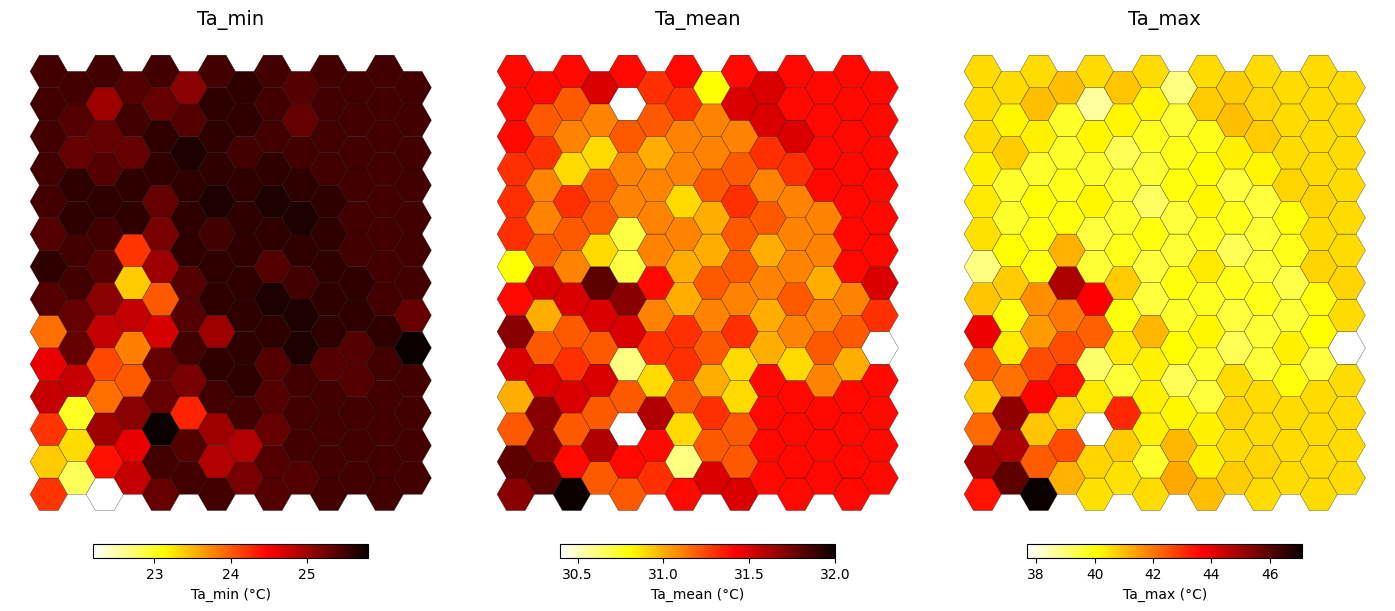

In [91]:
# Do the same, but on static maps, side by side

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"

# Make the static map

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name}_daily_stats_{variable}.png")
plot_daily_stats_on_static_map(MODEL_OUTPUT_FOLDER, MODEL_INPUT_FOLDER, variable, figname)

> Reading TARGET .npy output ...
File saved: True


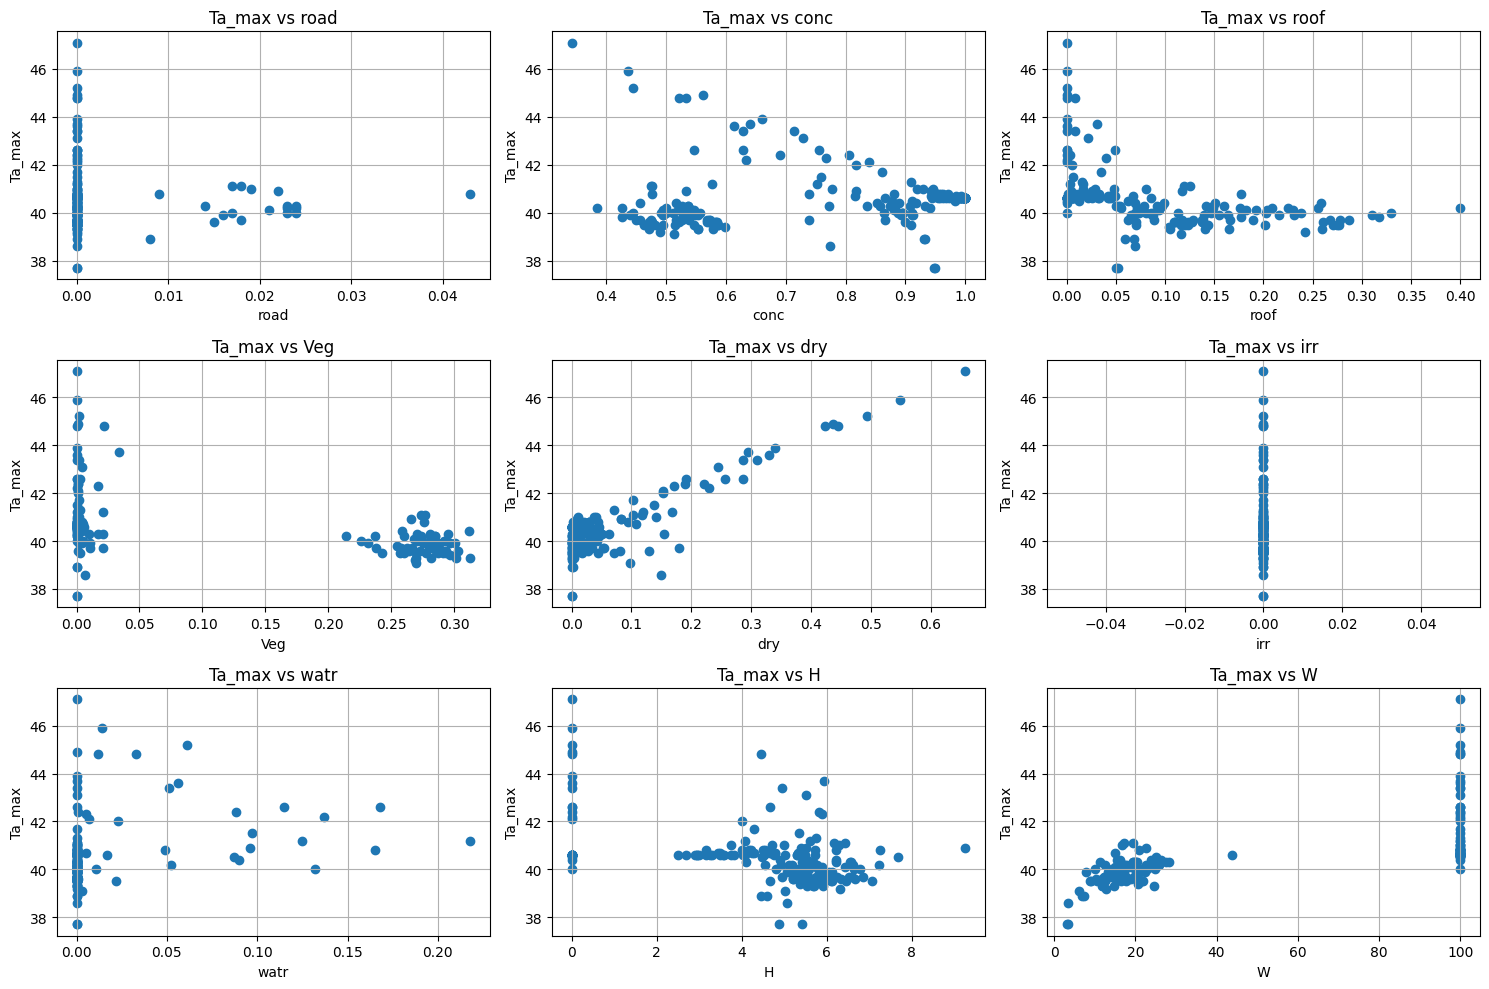

In [92]:
# Is the output visually related to the underlying surface?

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"

# What statistic of this variable do you want to explore?

variable_prop = 'max'  # or 'min', or 'max

# Make the scatterplots

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name}_scatter_{variable}_{variable_prop}_vs_surface.png")
scatter_variable_vs_surface(MODEL_OUTPUT_FOLDER, MODEL_INPUT_FOLDER, variable, variable_prop, figname)

> Reading TARGET .npy output ...
File saved: True


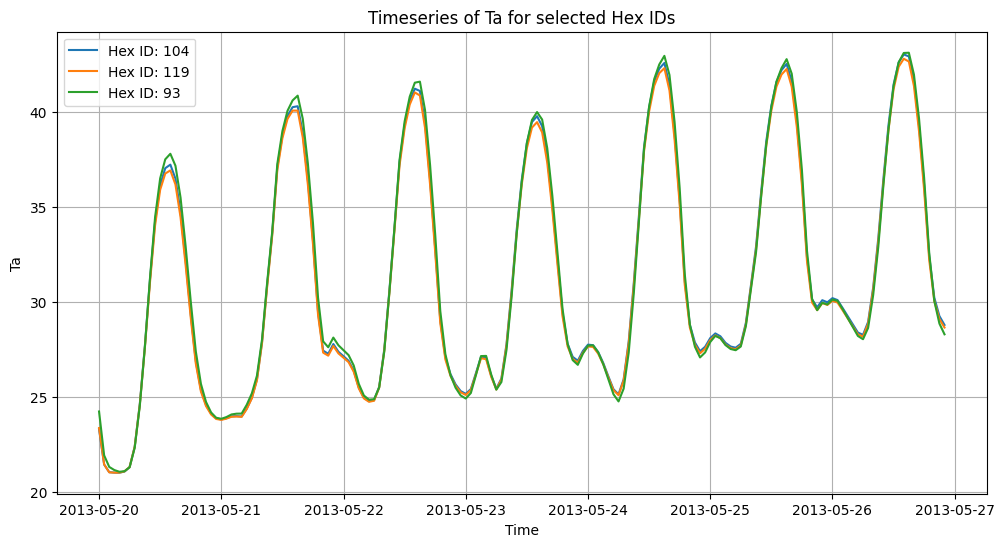

In [93]:
# Finally, plot timeseries for 3 pixels of interest.

# ==> For hex ID's, see interactive map by make_interactive_map_roi()

# Eg.
if city == 'Timbuktu':
    # hex_ids = [
    #     159,  # - pixel with highest fraction of buildings
    #     62,   # - pixel with highest fraction of trees
    #     102, # - pixel with highest fraction of water (inland)
    # ]
        hex_ids = [
        104,
        119,
        93,
    ]
elif city == 'Davao':
  hex_ids = [
      372,  # - pixel with highest fraction of buildings
      950,   # - pixel with highest fraction of trees
      149 # - pixel with highest fraction of water  (inland)
  ]

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"

# Plot the timeseries

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name}_timeseries_{variable}.png")
plot_timesereries_hex_of_interest(MODEL_OUTPUT_FOLDER, variable, hex_ids, figname)

# What if ...?

The scripts below allow you to compare your scenario against the baseline and assess the impact of such changes on the climate.

In order to do so, model outputs for both scenario_name = "baseline" and scenario_name = "XXX" are required!

In [94]:
# Show what has changed in the scenario.
# Note that for the more_trees scenario, we  increased the amount of tree cover by
# converting concrete surfaces into vegetated areas

variable = "Veg" # This is the tree cover fraction in TARGET

scenario_name_1 = "baseline"
# scenario_name_2 = "more_trees"
scenario_name_2 = "s1_targeted_greening"

MODEL_INPUT_FOLDER_BASE = os.path.join(SHARED_DIR, "data", city, model, scenario_name_1)
MODEL_INPUT_FOLDER_SCEN = os.path.join(SHARED_DIR, "data", city, model, scenario_name_2)

make_interactive_map_roi_compare(MODEL_INPUT_FOLDER_BASE, MODEL_INPUT_FOLDER_SCEN, variable=variable)

> Reading TARGET .npy output ...
> Reading TARGET .npy output ...
File saved: True


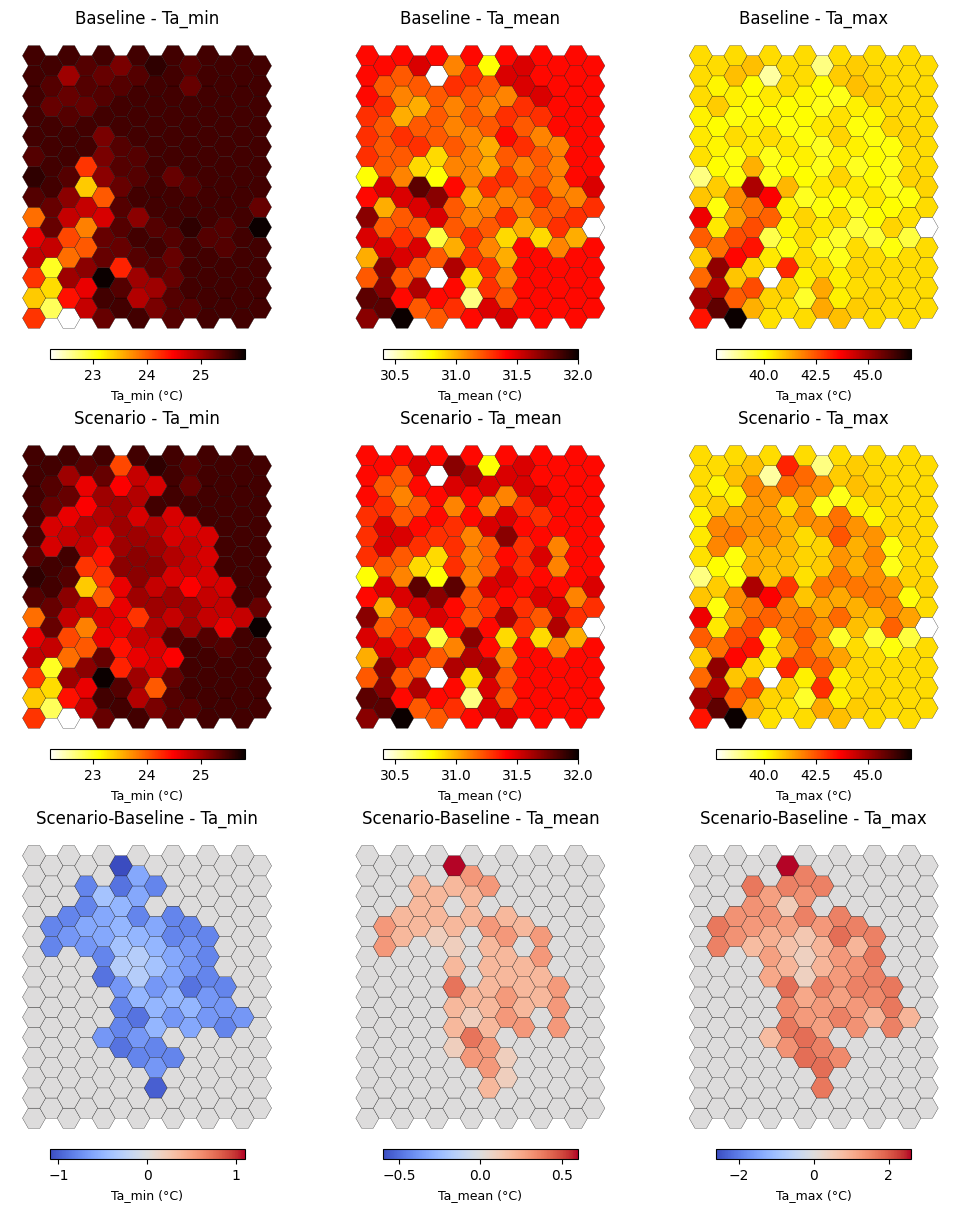

In [95]:
# Make static maps for two scenarions, and their difference

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"

scenario_name_1 = "baseline"
# scenario_name_2 = "more_trees"
scenario_name_2 = "s1_targeted_greening"

MODEL_OUTPUT_FOLDER_1 = os.path.join(PERSONAL_FOLDER, city, model, scenario_name_1)
MODEL_OUTPUT_FOLDER_2 = os.path.join(PERSONAL_FOLDER, city, model, scenario_name_2)

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name_1}_{scenario_name_2}_daily_stats_{variable}.png")
plot_daily_stats_on_static_map_scenarios(MODEL_OUTPUT_FOLDER_1, MODEL_OUTPUT_FOLDER_2, MODEL_INPUT_FOLDER, variable, figname)


> Reading TARGET .npy output ...
> Reading TARGET .npy output ...
File saved: True


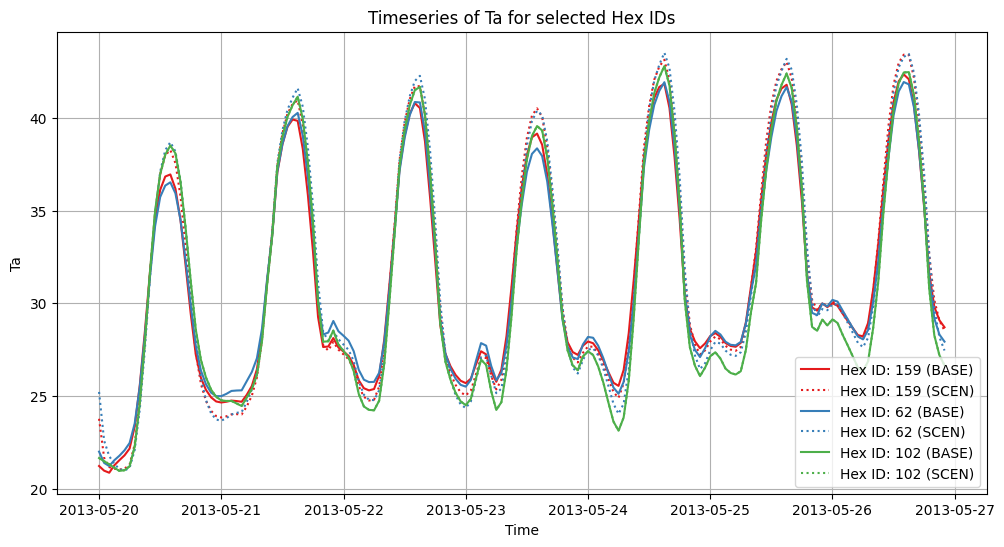

In [96]:
# Plot timeseries for 3 pixels of interest, this time for two scenarios

scenario_name_1 = "baseline"
# scenario_name_2 = "more_trees"
scenario_name_2 = "s1_targeted_greening"

MODEL_OUTPUT_FOLDER_1 = os.path.join(PERSONAL_FOLDER, city, model, scenario_name_1)
MODEL_OUTPUT_FOLDER_2 = os.path.join(PERSONAL_FOLDER, city, model, scenario_name_2)

# ==> For hex ID's, see interactive map by make_interactive_map_roi()

# Eg.
if city == 'Timbuktu':
    hex_ids = [
        159,  # - pixel with highest fraction of buildings
        62,   # - pixel with highest fraction of trees
        102, # - pixel with highest fraction of water (inland)
    ]
elif city == 'Davao':
  hex_ids = [
      372,  # - pixel with highest fraction of buildings
      950,   # - pixel with highest fraction of trees
      149 # - pixel with highest fraction of water  (inland)
  ]

# Select a variable you would like to look at:
# - Ws - wind speed
# - Ta - canyon air temperature
# - Ts_horz - surface temperature
# - Tmrt - mean radiant temperature
# - UTCI - universal thermal comfort index (Celsius degrees)

variable = "Ta"

# Plot the timeseries

figname = os.path.join(FIGURE_FOLDER, f"{model}_{city}_{scenario_name_1}_{scenario_name_1}_timeseries_{variable}.png")
plot_timesereries_hex_of_interest_scen(MODEL_OUTPUT_FOLDER_1, MODEL_OUTPUT_FOLDER_2, variable, hex_ids, figname)